# Homework 2, *part 2* (60 points)

In this assignment you will build a convolutional neural net (CNN) to solve Tiny ImageNet image classification. Try to achieve as high accuracy as possible.

## Deliverables

* This file,
* a "checkpoint file" from `torch.save(model.state_dict(), ...)` that contains model's weights (which a TA should be able to load to verify your accuracy).

## Grading

* 9 points for reproducible training code and a filled report below.
* 12 points for building a network that gets above 20% accuracy.
* 6.5 points for beating each of these milestones on the private **test** set:
  * 25.0%
  * 30.0%
  * 32.5%
  * 35.0%
  * 37.5%
  * 40.0%
  
*Private test set* means that you won't be able to evaluate your model on it. Rather, after you submit code and checkpoint, we will load your model and evaluate it on that test set ourselves (so please make sure it's easy for TAs to do!), reporting your accuracy in a comment to the grade.
    
## Restrictions

* Don't use pretrained networks.

## Tips

* One change at a time: never test several new things at once.
* Google a lot.
* Use GPU.
* Use regularization: L2, batch normalization, dropout, data augmentation.
* Use Tensorboard ([non-Colab](https://github.com/lanpa/tensorboardX) or [Colab](https://medium.com/@tommytao_54597/use-tensorboard-in-google-colab-16b4bb9812a6)) or a similar interactive tool for viewing progress.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.utils.data as data
from torchvision import transforms, utils
import torch.nn as nn
import torch.optim as optim
import time

%matplotlib inline

In [2]:
import tiny_imagenet
tiny_imagenet.download(".")

./tiny-imagenet-200 already exists, not downloading


Define helper functions:

In [3]:
def show_batch(sample_batched):
    plt.figure(figsize=(10,10))
    grid = utils.make_grid(sample_batched[0], padding=2, normalize=True)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    plt.title('Batch from dataloader')
    plt.axis('off')
    plt.ioff()
    plt.show()

In [4]:
def save_checkpoint(state, filename):
    torch.save(state, filename)

In [5]:
def accuracy(model, images, labels):
    with torch.no_grad():
        labels_pred = model.predict(images)
        numbers = labels_pred.argmax(dim=-1)
        return (numbers == labels).float().mean()

In [6]:
def make_layers(cfg, batch_norm=True):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

Network parameters:

In [7]:
EPOCHS = 50
TRAIN_DATA_PATH = "tiny-imagenet-200/train/"
VAL_DATA_PATH = "tiny-imagenet-200/val/"
BATCH_SIZE = 64
TRANSFORM_IMG = transforms.Compose([
    #transforms.Resize(64),
    #transforms.CenterCrop(32),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=90),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225] )
    ])
TRANSFORM_IMG_VAL = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225] )
    ])

Training and validation images are now in `tiny-imagenet-200/train` and `tiny-imagenet-200/val`.

Load it:

In [8]:
train_data = torchvision.datasets.ImageFolder(root=TRAIN_DATA_PATH,
                                              transform=TRANSFORM_IMG)
train_data_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4)

val_data = torchvision.datasets.ImageFolder(root=VAL_DATA_PATH,
                                            transform=TRANSFORM_IMG_VAL)
val_data_loader = data.DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4)

Plot some random batch:

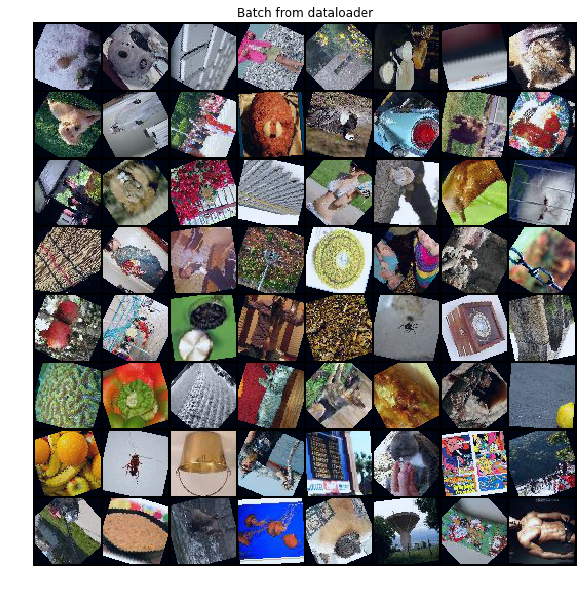

In [9]:
iterator = iter(train_data_loader)
show_batch(iterator.next())

Define network:

In [10]:
class Net(nn.Module):

    def __init__(self, features, num_classes=200, init_weights=True):
        super(Net, self).__init__()
        self.features = features
        self.avgpool = nn.AdaptiveAvgPool2d((2, 2))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 2 * 2, 512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, num_classes),
        )
        if init_weights:
            self._initialize_weights()
            
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)    

Instantiate it:

In [11]:
layers = make_layers([64, 64, 'M',\
                      128, 128, 'M',\
                      256, 256, 256, 256, 'M',\
                      512, 512, 512, 512, 'M',\
                      512, 512, 512, 512, 'M'])
net = Net(layers)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
loss_history = np.zeros(EPOCHS)
acc_history = np.zeros(EPOCHS)
train_loss_history = np.zeros(EPOCHS)
train_acc_history = np.zeros(EPOCHS)

Move to gpu (if neccesary):

_After training and saving weights, I downloaded notebook on my laptop thereby I switched to cpu backend_

In [12]:
ngpu = 2
#device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Cuda is available")
    net = net.cuda()
    if (ngpu > 1):
        net = nn.DataParallel(net, range(ngpu))
else:
    print('Cuda is not available')
    net = net.cpu()

Cuda is not available


Restore if it is needed:

In [14]:
WEIGHTS_PATH = './weights/model_best_lr01_sgd_50e.pth.tar'

if (torch.cuda.is_available()):
    checkpoint = torch.load(f=WEIGHTS_PATH)
else:
    net = nn.DataParallel(net)
    checkpoint = torch.load(map_location='cpu', f=WEIGHTS_PATH)
    
net.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer'])
last_epoch = checkpoint['epoch']
acc_history = checkpoint['acc_history']
loss_history = checkpoint['loss_history']
train_loss_history = checkpoint['train_loss_history']
train_acc_history = checkpoint['train_acc_history']

Train network:

In [17]:
count = 0
running_loss = 0

net.zero_grad()
for epoch in range(EPOCHS):
    # If this epoch has been already passed
    if (train_loss_history[epoch] > 0.1):
        print("###############################################")
        print("Epoch: " + str(epoch))
        print("Train Loss: ", round(train_loss_history[epoch], 2))
        if (loss_history[epoch] > 0.1):
            print("Train Accuracy: {}%".format(round(train_acc_history[epoch], 2)))
            print('Valid Loss: {}'.format(round(loss_history[epoch],2)))
            print('Valid Accuracy: {}%'.format(acc_history[epoch]))
        continue
    # otherwise train
    start = time.time()
    net.train()
    # Train on training dataset
    for steps, (x_batch, y_batch) in enumerate(train_data_loader):
        x_batch = x_batch.cuda()
        y_batch = y_batch.cuda()
        optimizer.zero_grad()
        predicted = net(x_batch)
        loss = criterion(predicted, y_batch)
        loss.backward()
        optimizer.step()
        running_loss = loss.item()
        
    end = time.time()
    train_loss_history[epoch] = loss
    print("###############################################")
    print("Epoch: " + str(epoch) + ", Time: " + str(round(end-start, 2)) + "s")
    print("Train loss: " + str(round(running_loss,2)))

    # Validate the model on every five steps
    if (epoch % 5 != 0):
        continue
        
    with torch.no_grad():
        # compute train acc
        correct = 0
        total = 0
        for images, labels in train_data_loader:
            images = images.cuda()
            labels = labels.cuda()
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        train_acc_history[epoch] = 100 * correct / total
        print('Train Accuracy: {}%'.format(100 * correct / total))

        net.eval()
        # compute val acc and loss
        correct = 0
        total = 0
        for images, labels in val_data_loader:
            images = images.cuda()
            labels = labels.cuda()
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            loss = criterion(outputs, labels)

        print('Valid Loss: {}'.format(round(loss.item(), 2)))
        print('Valid Accuracy: {}%'.format(100 * correct / total))
        acc_history[epoch] = 100 * correct / total
        loss_history[epoch] = loss

###############################################
Epoch: 0
Train Loss:  4.78
Train Accuracy: 3.12%
Valid Loss: 4.67
Valid Accuracy: 4.14%
###############################################
Epoch: 1
Train Loss:  5.08
###############################################
Epoch: 2
Train Loss:  4.14
###############################################
Epoch: 3
Train Loss:  4.01
###############################################
Epoch: 4
Train Loss:  4.19
###############################################
Epoch: 5
Train Loss:  3.89
Train Accuracy: 14.61%
Valid Loss: 3.78
Valid Accuracy: 16.59%
###############################################
Epoch: 6
Train Loss:  4.41
###############################################
Epoch: 7
Train Loss:  4.37
###############################################
Epoch: 8
Train Loss:  3.88
###############################################
Epoch: 9
Train Loss:  3.35
###############################################
Epoch: 10
Train Loss:  3.74
Train Accuracy: 23.26%
Valid Loss: 3.4
Valid Accur

Plot val loss, train loss and val acc, train acc

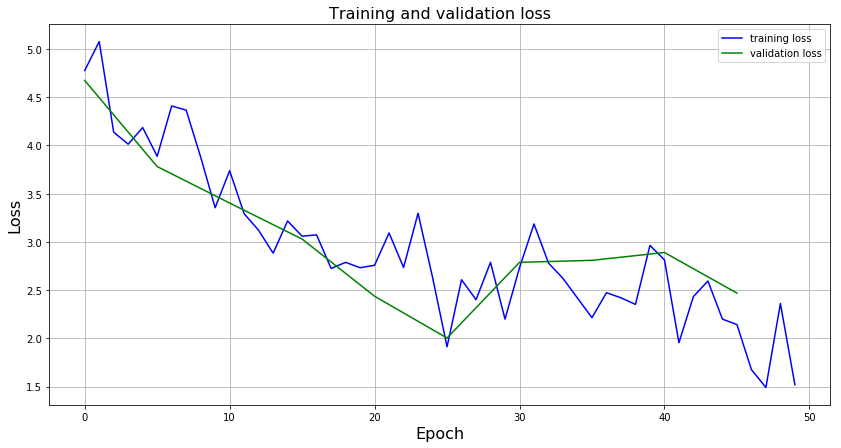

In [18]:
plt.figure(figsize=(14, 7))
plt.title("Training and validation loss", size=16)
plt.xlabel("Epoch", size=16)
plt.ylabel("Loss", size=16)
plt.plot(train_loss_history, 'b', label="training loss")
plt.plot(range(0, EPOCHS, 5), loss_history[0::5], 'g', label="validation loss")
plt.legend()
plt.grid()
plt.show()

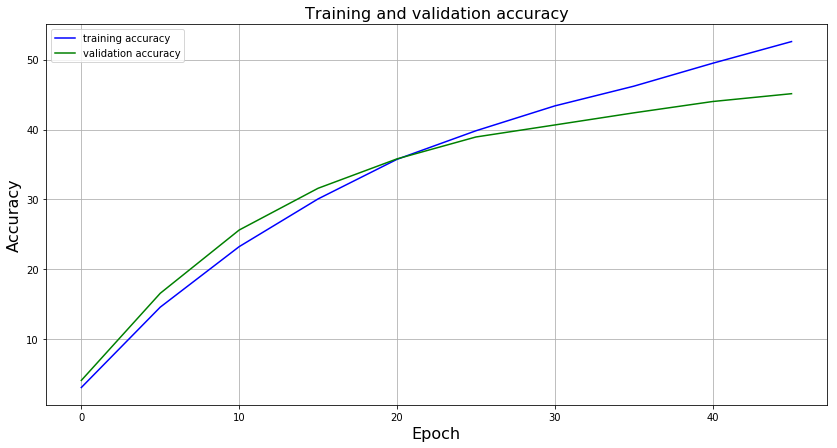

In [19]:
plt.figure(figsize=(14, 7))
plt.title("Training and validation accuracy", size=16)
plt.xlabel("Epoch", size=16)
plt.ylabel("Accuracy", size=16)
plt.plot(range(0, EPOCHS, 5), train_acc_history[0::5], 'b', label="training accuracy")
plt.plot(range(0, EPOCHS, 5), acc_history[0::5], 'g', label="validation accuracy")
plt.legend()
plt.grid()
plt.show()

### Do not run the cell below unless you know what to do!

In [ ]:
save_checkpoint({
        'epoch': epoch,
        'state_dict': net.state_dict(),
        'best_acc': acc_history[epoch-1],
        'best_loss': loss_history[epoch-1],
        'optimizer': optimizer.state_dict(),
        'acc_history' : acc_history,
        'loss_history' : loss_history,
        'train_loss_history' : train_loss_history,
        'train_acc_history' : train_acc_history
    }, './weights/model_best_lr01_sgd_rand.pth.tar')

When everything is done, please compute accuracy on the validation set and report it below.

In [20]:
net.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in val_data_loader:
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        loss = criterion(outputs, labels)
        
val_accuracy = correct / total
print("Validation accuracy: %.2f%%" % (val_accuracy * 100))

Validation accuracy: 46.48%


### Check test dataset

In [ ]:
TEST_DATA_PATH = ""

test_data = torchvision.datasets.ImageFolder(root=TEST_DATA_PATH,
                                            transform=TRANSFORM_IMG_VAL)
test_data_loader = data.DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4)

net.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_data_loader:
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        loss = criterion(outputs, labels)
        
test_accuracy = correct / total
print("Test accuracy: %.2f%%" % (test_accuracy * 100))

# Report

Below, please mention

* a brief history of tweaks and improvements;
* what is the final architecture and why?
* what is the training method (batch size, optimization algorithm, ...) and why?
* Any regularization and other techniques applied and their effects;

The reference format is:

*"I have analyzed these and these articles|sources|blog posts, tried that and that to adapt them to my problem and the conclusions are such and such".*